In [3]:
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import time
import uuid
import cv2
import albumentations as alb

In [7]:
"""for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data/back_numbers_deinterlaced', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data/back_numbers_deinterlaced','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data/back_numbers_deinterlaced',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) """

"for folder in ['train','test','val']:\n    for file in os.listdir(os.path.join('data/back_numbers_deinterlaced', folder, 'images')):\n        \n        filename = file.split('.')[0]+'.json'\n        existing_filepath = os.path.join('data/back_numbers_deinterlaced','labels', filename)\n        if os.path.exists(existing_filepath): \n            new_filepath = os.path.join('data/back_numbers_deinterlaced',folder,'labels',filename)\n            os.replace(existing_filepath, new_filepath) "

In [53]:
augmentor = alb.Compose([
                         alb.MotionBlur(blur_limit=41, p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data/back_numbers_deinterlaced', partition, 'images')):
        img = cv2.imread(os.path.join('data/back_numbers_deinterlaced', partition, 'images', image))

        coords = []
        labels = []
        label_path = os.path.join('data/back_numbers_deinterlaced', partition, 'labels', f'{image.split(".")[0]}.json')
        height, width,_ = img.shape
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                for i in range(len(label['shapes'])):
                    co = [0,0,0.00001,0.00001]
                    co[0] = label['shapes'][i]['points'][0][0]
                    co[1] = label['shapes'][i]['points'][0][1]
                    co[2] = label['shapes'][i]['points'][1][0]
                    co[3] = label['shapes'][i]['points'][1][1]
                    if co[0] > co[2]:
                        c = co[0]
                        co[0] = co[2]
                        co[2] = c
                    if co[1] > co[3]:
                        c = co[1]
                        co[1] = co[3]
                        co[3] = c
                    co = list(np.divide(co, [width,height,width,height]))
                    coords.append(co)
                    labels.append(label['shapes'][i]['label'])

        else:
            coords.append([0,0,0.00001,0.00001])
            labels.append("background")
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=coords, class_labels=labels)
                cv2.imwrite(os.path.join('data/datasets', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bboxes'] = [[0,0,0,0]]
                        annotation['class'] = ["background"] 
                    else: 
                        annotation['bboxes'] = augmented['bboxes']
                        annotation['class'] = augmented['class_labels']
                else: 
                    annotation['bboxes'] = [[0,0,0,0]]
                    annotation['class'] = ["background"]

                with open(os.path.join('data/datasets', partition, 'labels_old', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [62]:
def convert_labels_yolo(label_path):
    with open(label_path) as f:
        label = json.load(f)
    return label['class'], label['bboxes']

In [63]:
for partition in ['train','test','val']: 
    for file in os.listdir(os.path.join('data/datasets/', partition, 'labels_old')):
        path = os.path.join('data/datasets', partition, 'labels_old',file)
        labels , boxes = convert_labels_yolo(path)
        yolo = ""
        for i in range(len(labels)):
            if labels[i] =="background":
                break
            yolo = yolo + labels[i]+ ' '
            average_x = (boxes[i][2]+ boxes[i][0])/2
            average_y = (boxes[i][3]+ boxes[i][1])/2
            width = boxes[i][2]- boxes[i][0]
            height = boxes[i][3]- boxes[i][1]
            if i!= len(labels)-1:
                yolo+= "{} {} {} {}\n".format(average_x, average_y, width, height)
            else:
                yolo+= "{} {} {} {}".format(average_x, average_y, width, height)
        file_path = os.path.join('data' ,'datasets', partition, 'labels',file.split(".")[0]+ "."+ file.split(".")[1] + ".txt")
        with open(file_path, 'w') as file:
    
            # Write the string to the file
            file.write(yolo)

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config.yaml", epochs=10)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.205 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimiz

In [2]:
!sudo apt update
!sudo apt install -y libgl1-mesa-glx
!pip install opencv-python
!pip install ultralytics

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
62 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 21.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 29.1 MB/s eta 0:00:00



0: 576x640 1 0, 1 2, 1 4, 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


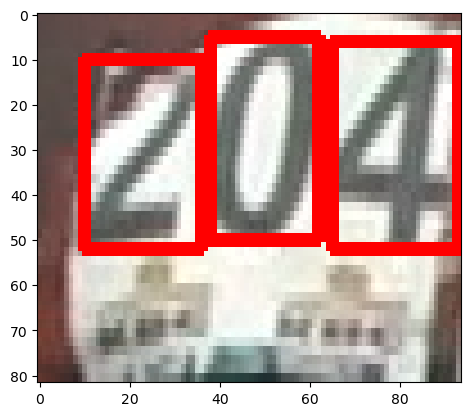

In [16]:
from ultralytics import YOLO
import os
import numpy as np
import cv2 as cv
import sys
from matplotlib import pyplot as plt

MODEL_PATH = os.path.join('runs','detect','train4','weights','best.pt')
model = YOLO(MODEL_PATH)

img = cv.imread("data/back_numbers_deinterlaced/test/images/f4b87855-7248-11ee-901a-fcb3bc5cd112.jpg")
results = model(img)
boxes = results[0].boxes.xyxy
for i in boxes:
    top = tuple([int(i[0].item()),int(i[1].item())])
    bottom = tuple([int(i[2].item()),int(i[3].item())])
    cv.rectangle(img,top,bottom, (255,0,0), 2)

plt.imshow(img)
